# Dataset Dossier for Training and Evaluation

**Project:** xai-med-classifier  
**Dataset Family:** MedMNIST  
**Default Benchmark Dataset:** `pathmnist`

---

## Purpose
This notebook provides an academically structured analysis of the dataset used in model development, training, and evaluation attempts. It documents provenance, split integrity, statistical properties, and methodological implications for reproducible medical-AI experimentation.

## Reproducibility and Runtime Setup

This notebook mirrors repository APIs in `src/xaimed/data/medmnist.py` and can download data automatically when needed.

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from medmnist import INFO

from xaimed.data.medmnist import build_medmnist_dataloaders, load_medmnist_dataset

sns.set_theme(style="whitegrid", context="talk")

## Configuration

In [2]:
DATASET_NAME = "pathmnist"
DATA_DIR = Path("data")
BATCH_SIZE = 64
NUM_WORKERS = 0
IMAGE_SIZE = 224
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DATA_DIR.mkdir(parents=True, exist_ok=True)

print({
    "dataset": DATASET_NAME,
    "data_dir": str(DATA_DIR),
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE,
})

{'dataset': 'pathmnist', 'data_dir': 'data', 'batch_size': 64, 'image_size': 224}


## 1) Dataset Metadata and Task Definition

In [3]:
dataset_key = DATASET_NAME.lower()
meta = INFO[dataset_key]

pd.Series({
    "task": meta.get("task"),
    "n_channels": meta.get("n_channels"),
    "n_samples": meta.get("n_samples"),
    "license": meta.get("license"),
    "description": str(meta.get("description", ""))[:300] + "...",
}, name="value")

task                                                 multi-class
n_channels                                                     3
n_samples           {'train': 89996, 'val': 10004, 'test': 7180}
license                                                CC BY 4.0
description    The PathMNIST is based on a prior study for pr...
Name: value, dtype: object

In [4]:
label_map = meta.get("label", {})
label_df = pd.DataFrame(
    [(int(k), v) for k, v in label_map.items()],
    columns=["class_index", "class_name"],
).sort_values("class_index").reset_index(drop=True)
label_df

,class_index,class_name
0,0,adipose
1,1,background
2,2,debris
3,3,lymphocytes
4,4,mucus
5,5,smooth muscle
6,6,normal colon mucosa
7,7,cancer-associated stroma
8,8,colorectal adenocarcinoma epithelium


## 2) Split Construction and Integrity Checks

In [5]:
split_datasets = {
    split: load_medmnist_dataset(
        dataset_name=DATASET_NAME,
        split=split,
        data_dir=DATA_DIR,
        download=True,
        transform=None,
    )
    for split in ("train", "val", "test")
}

split_df = pd.DataFrame({
    "split": ["train", "val", "test"],
    "count": [len(split_datasets["train"]), len(split_datasets["val"]), len(split_datasets["test"])],
})
split_df["proportion"] = split_df["count"] / split_df["count"].sum()
split_df

,split,count,proportion
0,train,89996,0.839672
1,val,10004,0.093338
2,test,7180,0.066990


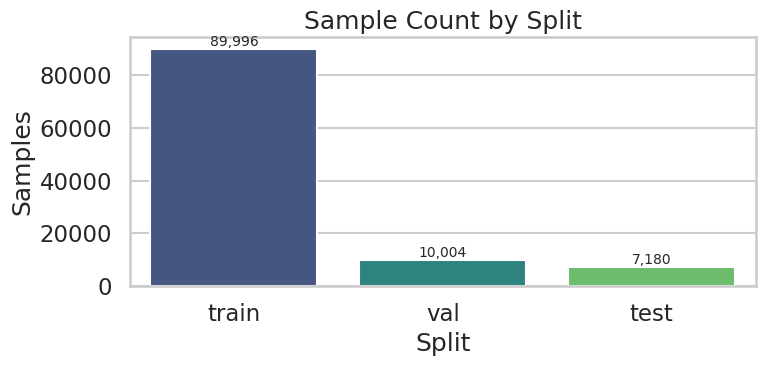

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(
    data=split_df,
    x="split",
    y="count",
    hue="split",
    palette="viridis",
    legend=False,
    ax=ax
)

ax.set_title("Sample Count by Split")
ax.set_xlabel("Split")
ax.set_ylabel("Samples")

for patch in ax.patches:
    h = patch.get_height()
    ax.annotate(
        f"{int(h):,}",
        (patch.get_x() + patch.get_width() / 2, h),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

## 3) Class Balance Across Splits

In [7]:
def extract_labels(ds):
    labels = np.array(ds.labels)
    return labels.reshape(-1)

rows = []
for split, ds in split_datasets.items():
    labels = extract_labels(ds)
    values, counts = np.unique(labels, return_counts=True)
    total = counts.sum()
    for v, c in zip(values, counts):
        rows.append({
            "split": split,
            "class_index": int(v),
            "count": int(c),
            "proportion": float(c / total),
        })

class_dist_df = pd.DataFrame(rows).merge(label_df, on="class_index", how="left")
class_dist_df

,split,class_index,count,proportion,class_name
0,train,0,9366,0.104071,adipose
1,train,1,9509,0.105660,background
2,train,2,10360,0.115116,debris
3,train,3,10401,0.115572,lymphocytes
4,train,4,8006,0.088960,mucus
5,train,5,12182,0.135362,smooth muscle
6,train,6,7886,0.087626,normal colon mucosa
7,train,7,9401,0.104460,cancer-associated stroma
8,train,8,12885,0.143173,colorectal adenocarcinoma epithelium
9,val,0,1041,0.104058,adipose


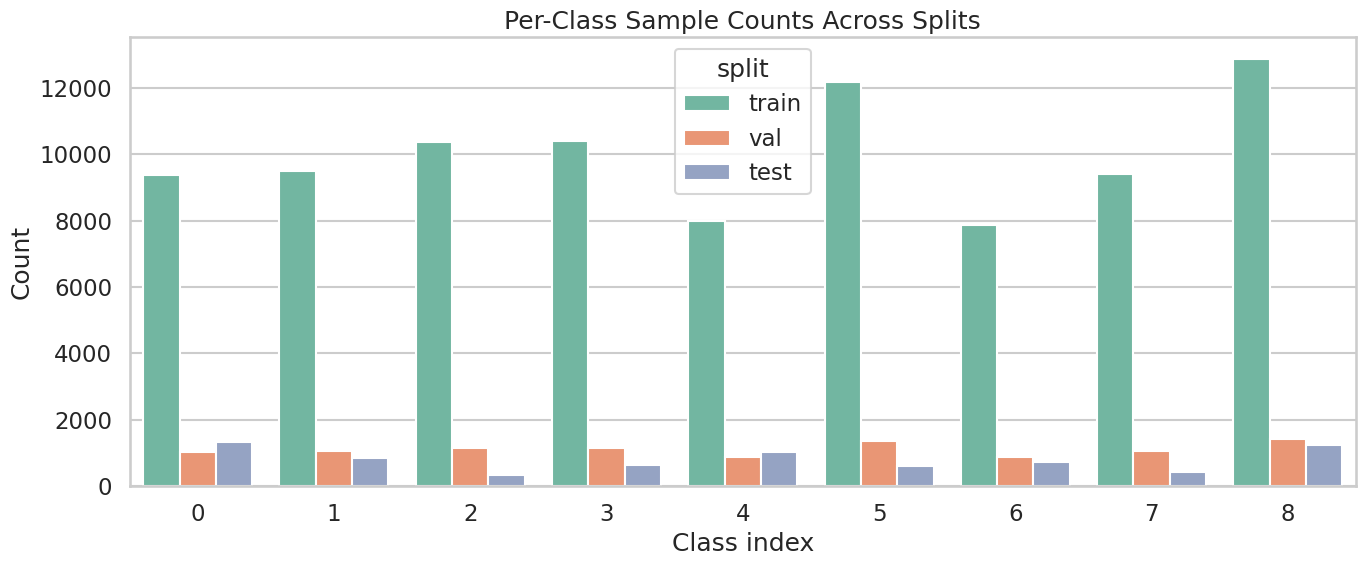

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=class_dist_df, x="class_index", y="count", hue="split", palette="Set2", ax=ax)
ax.set_title("Per-Class Sample Counts Across Splits")
ax.set_xlabel("Class index")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

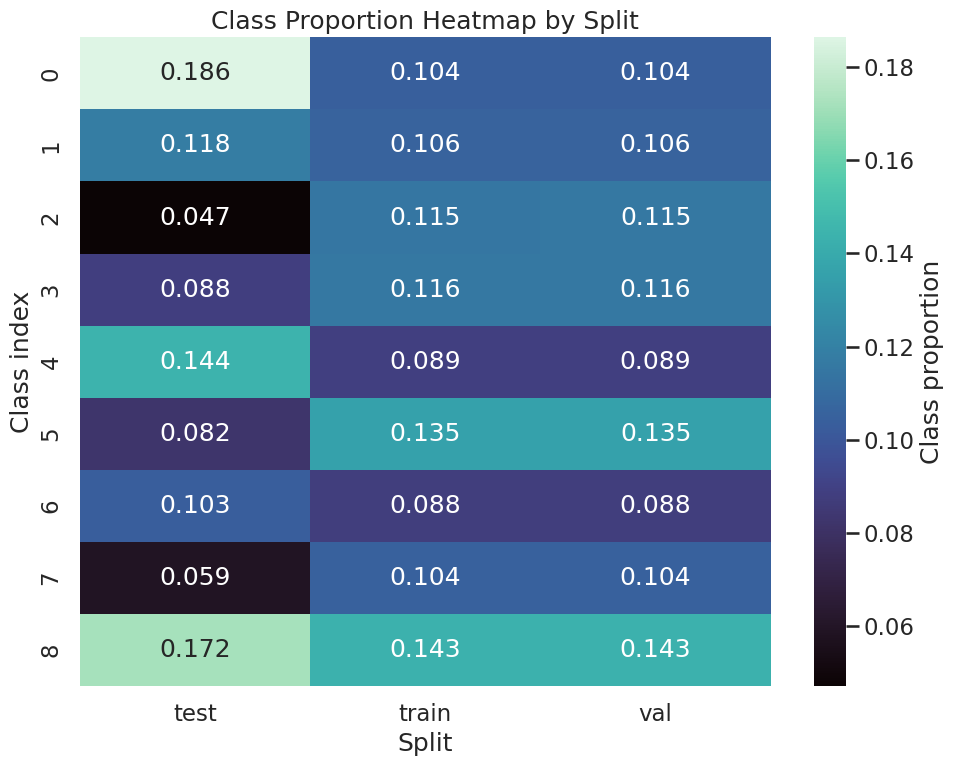

In [9]:
pivot_prop = class_dist_df.pivot(index="class_index", columns="split", values="proportion").fillna(0)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot_prop, annot=True, fmt=".3f", cmap="mako", cbar_kws={"label": "Class proportion"}, ax=ax)
ax.set_title("Class Proportion Heatmap by Split")
ax.set_ylabel("Class index")
ax.set_xlabel("Split")
plt.tight_layout()
plt.show()

## 4) Visual Audit: Sample Image Grid

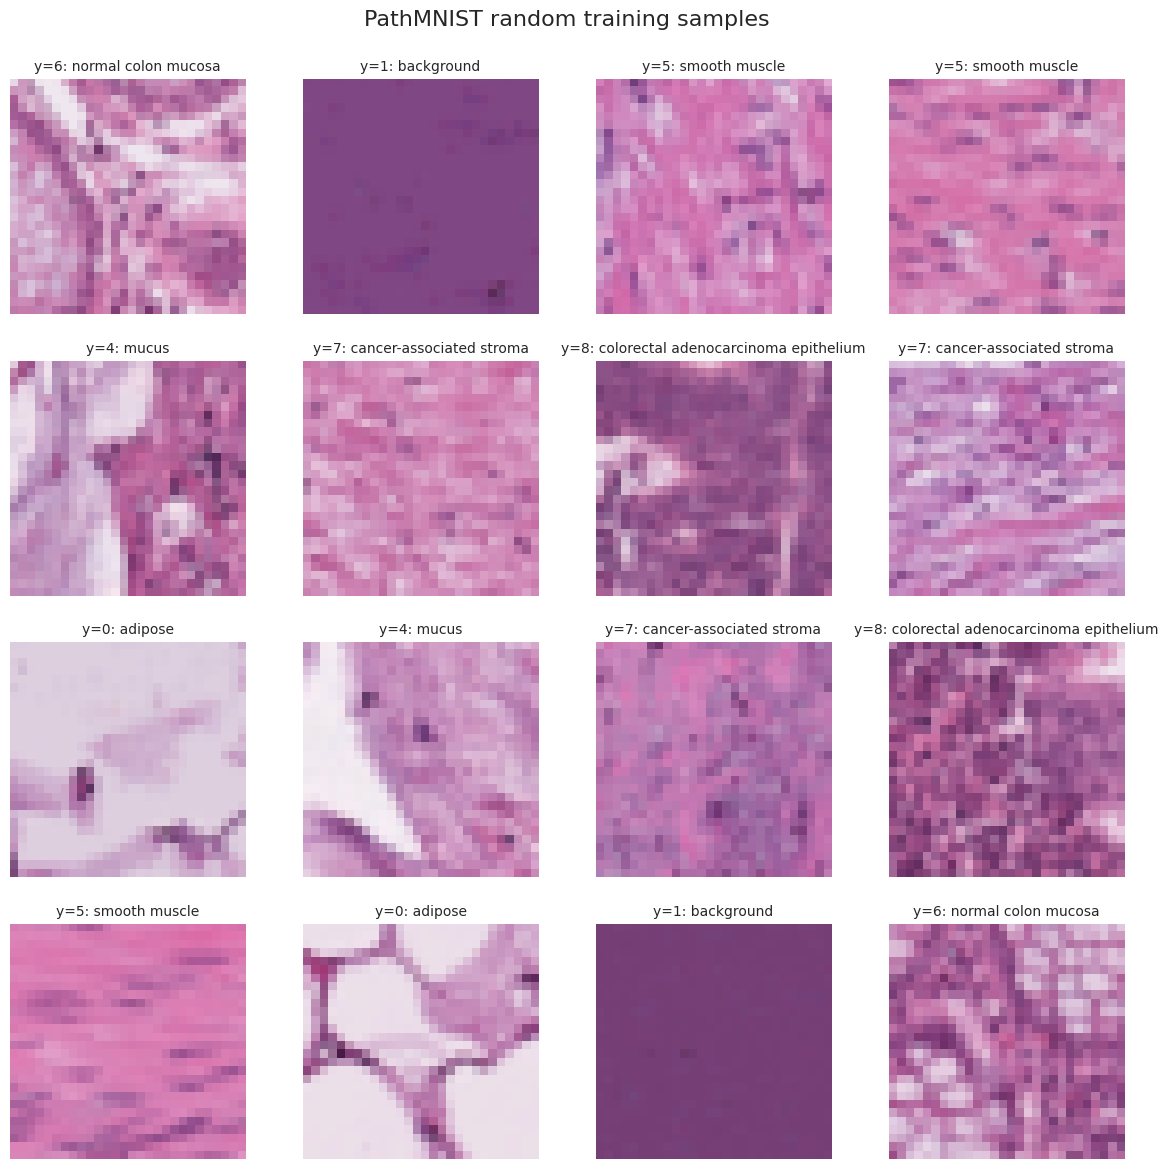

In [10]:
def show_random_samples(dataset, n=16, title="Random samples"):
    idx = np.random.choice(len(dataset), size=min(n, len(dataset)), replace=False)
    ncols = 4
    nrows = int(np.ceil(len(idx) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axes = np.array(axes).reshape(-1)

    for ax, i in zip(axes, idx):
        image, target = dataset[i]
        img = np.array(image)
        ax.imshow(img if img.ndim == 3 else img, cmap=None if img.ndim == 3 else "gray")
        label_idx = int(np.array(target).reshape(-1)[0])
        class_name = label_map.get(str(label_idx), str(label_idx))
        ax.set_title(f"y={label_idx}: {class_name}", fontsize=10)
        ax.axis("off")

    for ax in axes[len(idx):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_random_samples(split_datasets["train"], n=16, title="PathMNIST random training samples")

## 5) Pixel-Level Statistics and Distribution Diagnostics

In [11]:
def sample_pixels(dataset, n_images=1024):
    idx = np.random.choice(len(dataset), size=min(n_images, len(dataset)), replace=False)
    pixel_values, per_image_mean, per_image_std = [], [], []

    for i in idx:
        image, _ = dataset[i]
        arr = np.array(image).astype(np.float32)
        if arr.max() > 1.0:
            arr = arr / 255.0
        pixel_values.append(arr.reshape(-1))
        per_image_mean.append(arr.mean())
        per_image_std.append(arr.std())

    return {
        "pixels": np.concatenate(pixel_values),
        "image_mean": np.array(per_image_mean),
        "image_std": np.array(per_image_std),
    }

pixel_stats = sample_pixels(split_datasets["train"], n_images=2048)
print({
    "pixel_mean": float(pixel_stats["pixels"].mean()),
    "pixel_std": float(pixel_stats["pixels"].std()),
    "image_mean_mean": float(pixel_stats["image_mean"].mean()),
    "image_std_mean": float(pixel_stats["image_std"].mean()),
})

{'pixel_mean': 0.6650651097297668, 'pixel_std': 0.17099568247795105, 'image_mean_mean': 0.6650651693344116, 'image_std_mean': 0.1296834945678711}


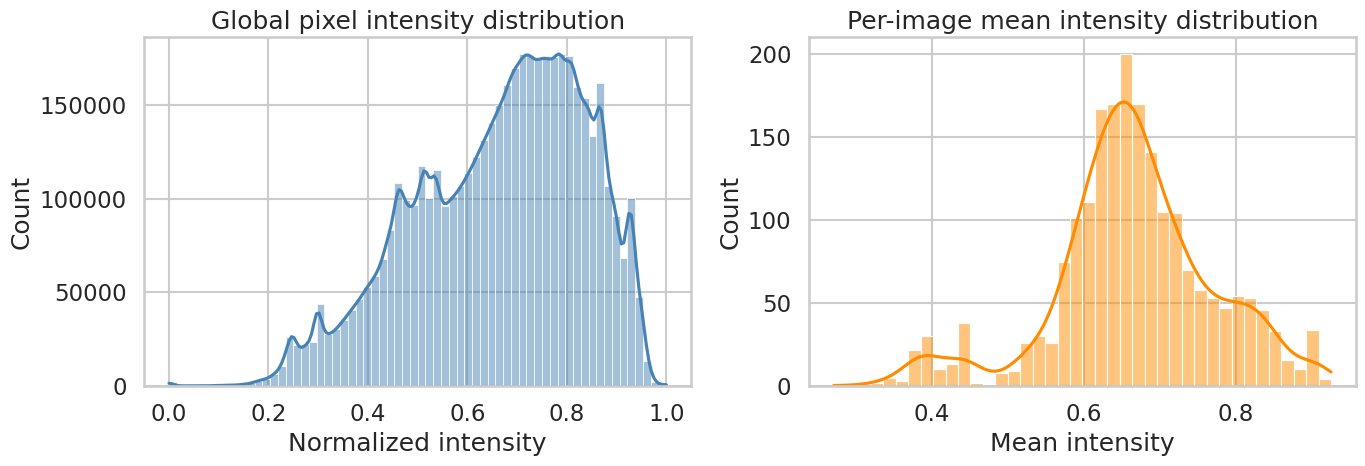

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(pixel_stats["pixels"], bins=64, kde=True, ax=axes[0], color="steelblue")
axes[0].set_title("Global pixel intensity distribution")
axes[0].set_xlabel("Normalized intensity")

sns.histplot(pixel_stats["image_mean"], bins=40, kde=True, ax=axes[1], color="darkorange")
axes[1].set_title("Per-image mean intensity distribution")
axes[1].set_xlabel("Mean intensity")

plt.tight_layout()
plt.show()

## 6) Training-Facing Data Interface Validation

In [13]:
dataloaders = build_medmnist_dataloaders(
    dataset_name=DATASET_NAME,
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    image_size=IMAGE_SIZE,
)

inputs, targets = next(iter(dataloaders["train"]))
print("Input batch shape:", tuple(inputs.shape))
print("Target batch shape:", tuple(targets.shape))
print("Input dtype:", inputs.dtype)
print("Target dtype:", targets.dtype)
print("Input range (approx):", float(inputs.min()), float(inputs.max()))

Input batch shape: (64, 3, 224, 224)
Target batch shape: (64, 1)
Input dtype: torch.float32
Target dtype: torch.int64
Input range (approx): -0.929411768913269 0.9450980424880981


## 7) Evaluation Design Notes (Methodological)

1. **No test leakage**: keep test split for terminal reporting only.
2. **Validation-governed model selection**: all hyperparameter and checkpoint selection should use validation metrics.
3. **Class-aware metrics**: report macro/weighted scores to account for imbalance.
4. **Uncertainty-aware claims**: use repeated-seed confidence intervals where possible.
5. **Explainability stratification**: evaluate XAI quality by class and failure mode, not only global averages.

## 8) Compact Readouts for Experiment Logs

In [14]:
summary_table = split_df.copy()
summary_table["count"] = summary_table["count"].map(lambda x: f"{x:,}")
summary_table["proportion"] = summary_table["proportion"].map(lambda x: f"{x:.3f}")
summary_table

,split,count,proportion
0,train,"89,996",0.840
1,val,"10,004",0.093
2,test,"7,180",0.067


In [15]:
class_balance_readout = (
    class_dist_df.groupby(["class_index", "class_name"], as_index=False)["count"].sum()
    .sort_values("class_index")
)
class_balance_readout

,class_index,class_name,count
0,0,adipose,11745
1,1,background,11413
2,2,debris,11851
3,3,lymphocytes,12191
4,4,mucus,9931
5,5,smooth muscle,14128
6,6,normal colon mucosa,9504
7,7,cancer-associated stroma,10867
8,8,colorectal adenocarcinoma epithelium,15550


---

## Conclusion
This notebook produces a publication-grade dataset profile for the training/evaluation pipeline and can be rerun prior to any experimental cycle to document data state and distribution.